# HW 5  - Walter Zesk
Load dependencies -- including custom wave_model.py

Load Pre-filtered Nantucket bouy data (just period and amplitude) from problem set #2

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import importlib.util
spec = importlib.util.spec_from_file_location("wave_model", "../wave_model.py")
wm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(wm)

waves_in = np.loadtxt('data/period_amp.csv',delimiter=',')

Use wave model to simulate additional wave properties for each wave sampled and save results to new file.

1. calculate the value of the Lagrangian surface (z=0) Stokes drift for the entire 1-year record.   

In [24]:
depth = 75
calculated_wave = []
wave_out = open('data/drift_out.csv','w')
for w in waves_in:
    #solve wave and get some basic properties
    my_wave = wm.wave_solver(w[0],depth,w[1])
    wave_row = w

    #stokes drift at z = 0
    wave_row = np.append(wave_row,my_wave.stokes_drift(0))
    
    #write to array
    write_line = ",".join(map(str, wave_row))
    wave_out.write(write_line+'\n')
    calculated_wave.append(wave_row)
    
#save to new file
wave_out.close()

Read in simulated data and transpose for visualization.

In [25]:
read_waves = np.loadtxt('data/drift_out.csv',delimiter=',',usecols = (0,1,2))
read_waves = read_waves.transpose()

measurements = []
steepness = []
for i in range(0,len(read_waves[2])):
    measurements.append(i)
    steepness.append(read_waves[1][i]/read_waves[0][i])
    
#setup array for plotting with stokes drift and steepness
wave_comparison = [read_waves[2],steepness]

 Make a plot of this quantity as a function of time. Assume the depth is 75m and that the wave amplitude (a) is half the reported significant wave height.
 Discuss under what conditions, the surface stokes drift is highest.
 **The zoomed in view below shows a clear correlation between wave steepness and stokes drift.  The drift grows with wave steepness.**

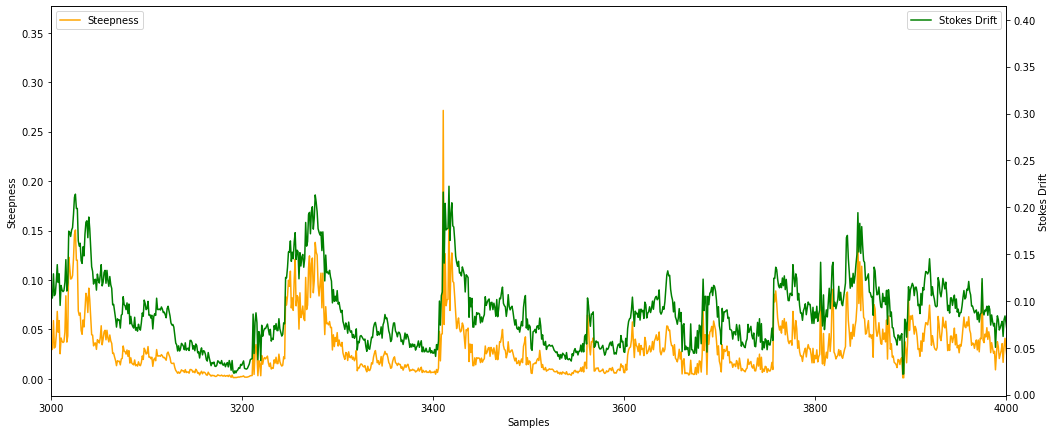

In [26]:
fig, (axs1) = plt.subplots(1, 1,figsize=(14, 6))
fig.tight_layout(h_pad=5,w_pad=5)

titles =["langrangian stokes drift at Z=0"]
colors = ["orange","green"]
labels=["Steepness","Stokes Drift"]
locs = ['upper left','upper right']
    
i=0
axes=fig.get_axes()
axes.append(axes[0].twinx())  # instantiate a second axes that shares the same x-axis
for color in colors:
    axes[i].plot(measurements,wave_comparison[i],color=color,label=labels[i])
    axes[i].set(xlabel="Samples", ylabel=labels[i])
    axes[i].autoscale()
    axes[i].set_xlim(3000,4000)
    axes[i].legend(loc=locs[i])
    i+=1
    
plt.show()

2.	Calculate the depth-integrated mass flux for a wave with a height of 1m (a = 0.5m) and wave period of 15s as it propagates from deep water to a depth of 5m.  

Include shoaling (as in problem set #3) in your calculation.  

No handles with labels found to put in legend.
No handles with labels found to put in legend.


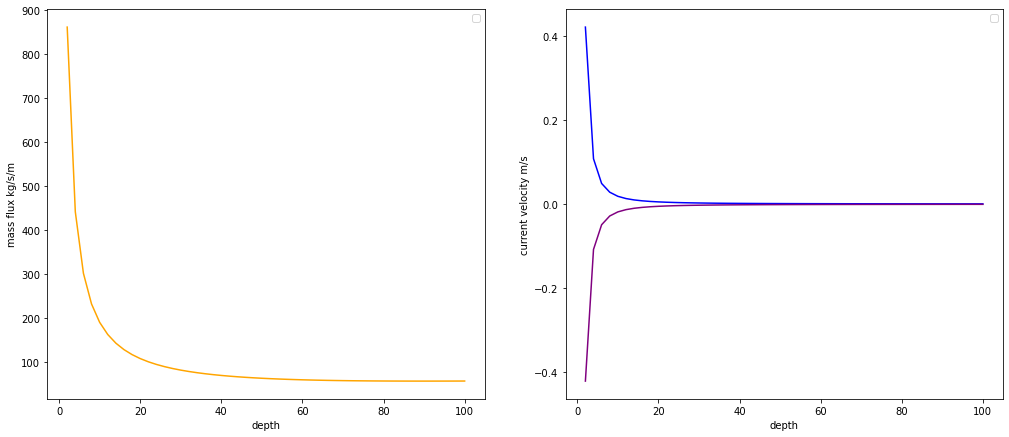

In [30]:
mass_wave = wm.wave_solver(15,100,0.5)
depths=np.arange(100,0,-2)

mass_fluxes=[]
currents=[]
return_flow=[]
for depth in depths:
    flux,current=mass_wave.integrated_mass_flux(depth)
    mass_fluxes.append(flux)
    currents.append(current)
    return_flow.append(current*-1)

fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(14, 6))
fig.tight_layout(h_pad=5,w_pad=5)

titles =["integrated mass flux","integrated current"]
yl =["mass flux kg/s/m","current velocity m/s"]
colors = ["orange","blue","purple"]
    
i=0
axes = fig.get_axes()
axes[0].plot(depths,mass_fluxes,color=colors[0])
axes[1].plot(depths,currents,color=colors[1])
axes[1].plot(depths,return_flow,color=colors[2])
for axs in axes:
    axs.set(xlabel="depth", ylabel=yl[i])
    axs.autoscale()
    axs.legend(loc='upper right')
    i+=1
    
plt.show()


Discuss how the resulting depth averaged current varies with depth.  Given that there cannot be a mean flow through the coastline, what are the implications for the across-shelf circulation.
**As the waves shoal, the mass flux increases, along with wave height and steepness until they break.  This mass results in the surface setup and return mass flow along the bottom.**

What might a Eulerian current meter at a depth of 10m measure?
**The Eulerian current meter would measure zero [_after reviewing the HW solution, I omitted the return mass transport below the wave troughs, even though I identified that requirement in my answer above_] -- in an Eulerian reference frame the positive stokes drift happens within the amplitude of the wave.**

question: **I seem to be calculating higher than expected flux and current.**

3.	The Lagrangian Stokes drift velocity profile was presented in class.
a.	Derive an expression for the Stokes drift velocity profile [Us(z)] in terms of the sea surface frequency spectrum [S(f)].
b.	Use this expression in conjunction with the Chesapeake Bay Data pressure data to calculate the Stokes drift velocity profile.  For these calculations, only consider frequencies between (1/10 and 1 Hz) and assume that S = Spp, when pressure is measured in decibars.

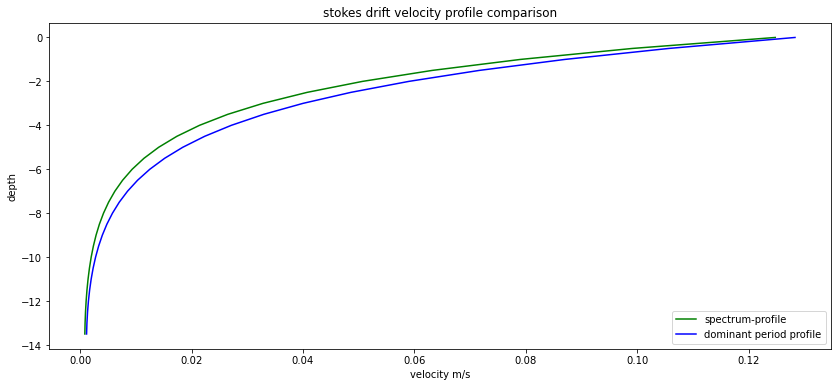

In [39]:
from scipy import stats
CB_data = np.loadtxt('data/ADV_data_CB_out1.csv',delimiter=',',skiprows=1)
#CB: water depth is 14m
#data was collected 1.8m below the mean sea surface (z = -1.8m)
#data order: dn,P,u,v,w
CB_data = CB_data.transpose()
depths=np.arange(10,0,-1)

#setup plots
fig, (axs1) = plt.subplots(1, 1,figsize=(14, 6))
titles =["stokes drift velocity profile comparison","dominant period profile"]
colors = ["green","blue"]
labels=["spectrum-profile","dominant period profile"]    

#calculate spectrum
pf, CB_Pxx_press = signal.welch(CB_data[1], 32, nperseg=1024)
CB_Pxx_surface = CB_Pxx_press #just renaming variable because sea surface height above sensor is equal to pressure measured in decibars


#trim spectrum to ocean wave frequencies
trim_f = [] 
trim_surf = [] 
for i in range(len(pf)):
    if pf[i] > 0.1 and pf[i] < 1:
        trim_f.append(pf[i])                # trimmed frequencies
        trim_surf.append(CB_Pxx_surface[i]) # trimmed sea surface 

#find dominant period
psd = np.column_stack([trim_f,trim_surf])
def get_first(e):
    return e[1]
psd = sorted(psd,key=get_first)

#depths to sample velocity at
flow_depths = np.arange(0,-14,-0.5)

#caculate velocity from full spectrum and dominant period
flows = []
dominant_flows = []
for depth in flow_depths:
    drift_spectrum = wm.integrated_stoke_drift(trim_surf,trim_f,14,depth)#caculate for full spectrum
    flows.append(np.sum(drift_spectrum))#sum velocity across spectrum
    dominant_flows.append(wm.stoke_drift_from_spectrum(np.sqrt(psd[-1][1]),psd[-1][0],14,depth))#calculate for dominante period

#visualize profiles side by side
axes = fig.get_axes()
axes[0].plot(flows,flow_depths,color=colors[0],label=labels[0])
axes[0].plot(dominant_flows,flow_depths,color=colors[1],label=labels[1])


axes[0].set(ylabel="depth", xlabel="velocity m/s")
axes[0].autoscale()
axes[0].legend(loc='lower right')
axes[0].set_title(titles[0])

    
plt.show()

c.	How does this profile compare with the estimate from linear wave theory based on the dominant wave period. 
**The two profiles decay proportionately.  The total velocity contributions of all spectra between .1 and 1 is double
the contribution of just the dominant period.**